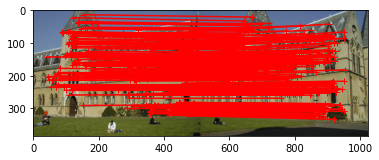

[[460.0805   104.9175   406.3635    82.941   ]
 [382.9605   108.0555   334.3105    93.6585  ]
 [106.718    102.545    115.988    109.5505  ]
 ...
 [231.88115  103.41166  207.82166  101.60805 ]
 [384.81      78.406745 336.47062   60.910215]
 [443.79631   67.695265 392.18692   42.129562]]
[[-2.80545239e-06  1.02603594e-04 -1.94387013e-02]
 [-3.36903711e-04  5.98945275e-06  5.47745171e-01]
 [ 7.88887677e-02 -4.95373844e-01 -1.26586724e+01]]
0.2452036154600043


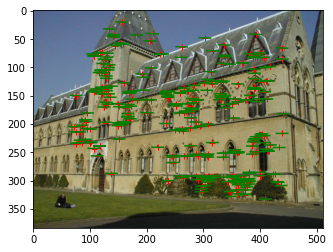

In [36]:
# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation
## Fundamental Matrix Estimation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from math import sqrt



##
## load images and match files for the first example
#

I1 = Image.open('MP4_part2_data/library1.jpg')
I2 = Image.open('MP4_part2_data/library2.jpg')
matches = np.loadtxt('MP4_part2_data/library_matches.txt'); 
# I1 = Image.open('MP4_part2_data/lab1.jpg')
# I2 = Image.open('MP4_part2_data/lab2.jpg')
# matches = np.loadtxt('MP4_part2_data/lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1
I3[:,I1.size[0]:,:] = I2
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3/255.).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
print(matches)
##
## display second image with epipolar lines reprojected 
## from the first image
##

def normalization(m):

    n = len(m)
    mean = np.mean(m, axis=0)
    m_mean = m - mean

    s = sqrt(1 / (2 * n) * sum(m_mean[:, 0]**2 + m_mean[:, 1]**2))
    t = np.array([[1/s, 0, -1 / s * mean[0]], [0, 1 / s, -1 / s * mean[1]], [0, 0, 1]])
  
    m = np.concatenate((m, np.ones((n, 1))), axis=1)
    m = np.dot(t, m.T).T

    return m[:, 0:2], t






def fit_fundamental(matches):


    normalize = True

    m1 = matches[:, :2]
    m2 = matches[:, 2:]

    if normalize:
        m1, t1 = normalization(m1)
        m2, t2 = normalization(m2)




    l = len(m1)

    index = sample(range(l), 8)
    list1 = m1[index]
    list2 = m2[index]

    M = []
    for i in range(8):
        p1 = list1[i]
        p2 = list2[i]

        r = [p2[0]*p1[0], p2[0]*p1[1], p2[0], p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1]
        M.append(r)

    M = np.array(M)

    U, S, V = np.linalg.svd(M)
    
    f = V[-1].reshape(3, 3)
    f = f / f[-1, -1]


    u, s, v = np.linalg.svd(f)

    diag = np.diag(s)
    diag[-1, -1] = 0

    f = np.dot(np.dot(u, diag), v)

    if normalize:
        return np.dot(np.dot(t2.T, f), t1)
 
    return f
    

# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write
print(F)
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())


print(np.mean(np.abs(pt_line_dist)))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2))#.astype(float))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()





Fundamental matrix estimation without ground-truth matche

In [37]:
import cv2
import scipy 
from pylab import *
from scipy.spatial import distance
from random import sample

In [38]:
img1 = cv2.imread('MP4_part2_data/gaudi1.jpg')

img1_g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('MP4_part2_data/gaudi2.jpg') 

img2_g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1_g, None)


kp2, des2 = sift.detectAndCompute(img2_g, None)


In [56]:
res = scipy.spatial.distance.cdist(des1, des2,'sqeuclidean')

thresh_val = 8000

thresh = np.where(res <  thresh_val, res, 0)

nozero = np.transpose(np.nonzero(thresh))

matches = np.zeros((len(nozero),4))

index = 0
for i in nozero:

    k1 = kp1[i[0]].pt
    k2 =  kp2[i[1]].pt
    matches[index, :] = [k1[0], k1[1], k2[0], k2[1]]
    index += 1

print(len(matches))

14


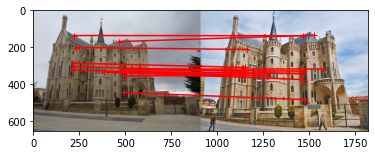

In [57]:
I1 = Image.open('MP4_part2_data/gaudi1.jpg')
I2 = Image.open('MP4_part2_data/gaudi2.jpg')


N = len(matches)

I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1
I3[:,I1.size[0]:,:] = I2
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I3/255.).astype(float))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()


5.7860551794006545


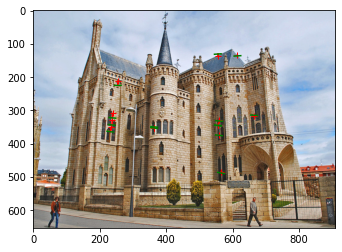

In [58]:
# first, fit fundamental matrix to the matches
F = fit_fundamental(matches); # this is a function that you should write

M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())


print(np.mean(np.abs(pt_line_dist)))

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(np.array(I2))#.astype(float))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()

Camera Calibration

In [59]:
def projection_matrice(points_2d, points_3d):
    
    n = len(points_3d)
    points_3d = np.concatenate((points_3d, np.ones((n,1))), axis=1)
    A = []



    for i in range(n):
        r = [0, 0, 0, 0]
        r1 = np.concatenate((r, points_3d[i], -points_2d[i][1]*points_3d[i]), axis = 0)
        r2 = np.concatenate((points_3d[i], r,  -points_2d[i][0]*points_3d[i]), axis = 0)
        A.append(r1)
        A.append(r2)
    
    #print(np.array(A).shape)
    U, s, V = np.linalg.svd(A)
    P  = V[len(V)-1]
    P = P.reshape((3, 4))
    # print(P)

    return P

    

In [60]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

matches_2d = np.loadtxt('MP4_part2_data/lab_matches.txt')
points_3d = np.loadtxt('MP4_part2_data/lab_3d.txt')

lab1 = matches_2d[:, :2]
lab2 = matches_2d[:, 2:]


lab1_m = projection_matrice(lab1, points_3d)
lab2_m = projection_matrice(lab2, points_3d)

print(lab1_m)
print(lab2_m)

points_3d_proj1, residual1 = evaluate_points(lab1_m ,lab1, points_3d)

points_3d_proj2, residual2 = evaluate_points(lab2_m, lab2, points_3d)


print(residual1)
print(residual2)



[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
13.545832900248698
15.544953457947923


center

In [61]:
cam1 = np.loadtxt('MP4_part2_data/library1_camera.txt')
cam2 = np.loadtxt('MP4_part2_data/library2_camera.txt')

def center(cam):
    U, s, V = np.linalg.svd(cam)
    c = V[len(V)-1]
    return c / c[-1]

print("lib1_cam:  ")
lib1_c = center(cam1)
print(lib1_c)
print("lib2_cam:  ")
lib2_c = center(cam2)
print(lib2_c)
print("lab1_cam:  ")
lab1_c = center(lab1_m)
print(lab1_c)
lab2_c = center(lab2_m)
print("lab2_cam:  ")
print(lab2_c)
        



lib1_cam:  
[  7.28863053 -21.52118112  17.73503585   1.        ]
lib2_cam:  
[  6.89405488 -15.39232716  23.41498687   1.        ]
lab1_cam:  
[305.83276769 304.20103826  30.13699243   1.        ]
lab2_cam:  
[303.10003925 307.18428016  30.42166874   1.        ]


Triangulation

In [62]:
def residual(points_2d, points_3d, m):
    res = 0
    n = len(points_3d)
    for i in range(n):
        cur = np.matmul(m, points_3d[i])
        cur = cur / cur[-1]

        res += sum((cur[:2]-points_2d[i])**2)

    return res / n


resideul
0.07312796424286495
0.2676795126175843


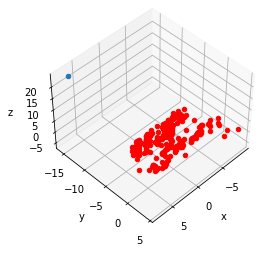

In [63]:
matches_2d = np.loadtxt('MP4_part2_data/library_matches.txt')
points_3d = np.loadtxt('MP4_part2_data/lab_3d.txt')

n = len(matches_2d)

p1 = np.concatenate((matches_2d[:, :2], np.ones((n, 1))), axis=1)
p2 = np.concatenate((matches_2d[:, 2:], np.ones((n, 1))), axis=1)


points = []

for i in range(n):
    k1 = [[0, -p1[i][2], p1[i][1]], [p1[i][2], 0, -p1[i][0]], [-p1[i][1], p1[i][0], 0]]

    k2 = [[0, -p2[i][2], p2[i][1]], [p2[i][2], 0, -p2[i][0]], [-p2[i][1], p2[i][0], 0]]

    #A = np.vstack((np.matmul(k1, lab1_m), np.matmul(k2, lab2_m)))
    A = np.vstack((np.matmul(k1, cam1), np.matmul(k2, cam2)))

    U, s, V = np.linalg.svd(A)
    p = V[len(V)-1]
    points.append(p / p[-1])



#print(points)
print("resideul")
# print(residual(matches_2d[:, :2], points, lab1_m))
# print(residual(matches_2d[:, 2:], points, lab2_m))

print(residual(matches_2d[:, :2], points, cam1))
print(residual(matches_2d[:, 2:], points, cam2))



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.scatter(lib1_c[0], lib1_c[1], lib1_c[2])
ax.scatter(lib2_c[0], lib2_c[1], lib2_c[2])
# ax.scatter(lab1_c[0], lab1_c[1], lab1_c[2])
# ax.scatter(lab2_c[0], lab2_c[1], lab2_c[2])
for i in range(len(points)):
    ax.scatter(points[i][0], points[i][1], points[i][2], c='red')

ax.view_init(45, 45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

